# Info.
- unofficial implementation of [ADC: Advanced document clustering using contextualized representations]
- dataset used for clustering
    - https://arxiv.org/abs/2004.12765
    - Download here: https://www.kaggle.com/datasets/deepcontractor/200k-short-texts-for-humor-detection

# Model

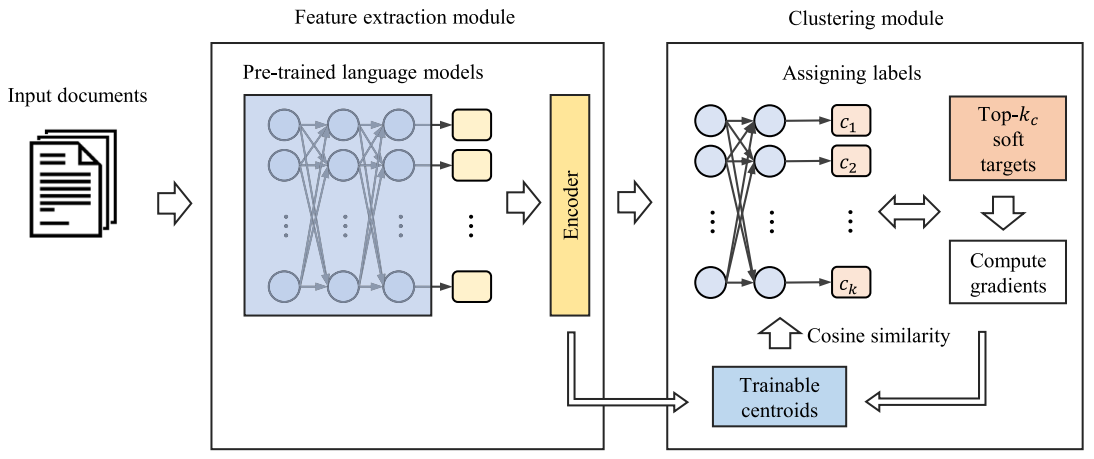

- Centriod initialization
    - $\mu = \{\mu_j\}_{j=1}^k$
- Feature extraction
    - Documents $d = \{d_i\}_{i=1}^B$. ($B$ is batch size)
    - Tokenize $d$.
    - Feed the tokens into a PLM.
    - Get the mean of the token embeddings --> the features of $d$ obtained.
- Clustering
    - Get cosine similarities, $s_{ij} = cos(d_i, \mu_j)$.
    - Get membership probability, $p_i = Softmax(s_i)$.
    - Get cluster assignments, $\tilde{y_i} = \underset{j}{argmax}(p_{ij})$
        - Which cluster has the highest probability on each document.
    - Get top-$k_c$ samples that have the highest similarities ($s$) with the centroids.
        - Parameters only updated wrt these samples.
    - $Loss = \mathbb{E}[NLL(p_i, \tilde{y}_i)]$
***
- Considerations
    - NO update for the PLM parameters.
    - SGD used for optimization.

# Pytorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

print(torch.__version__)

1.12.0


# Data

In [2]:
### Load the dataset
import pandas as pd

data = pd.read_csv("humor_texts.csv")
data.tail(3)

,text,humor
199997,How many optometrists does it take to screw in...,True
199998,Mcdonald's will officially kick off all-day br...,False
199999,An irish man walks on the street and ignores a...,True


In [3]:
### Select humor texts only
data = data[data["humor"]==True]
len(data)

100000

# PLM

In [4]:
from sentence_transformers import SentenceTransformer

plm = SentenceTransformer("all-mpnet-base-v2")
plm.max_seq_length = 384 # <-- This is the maximum length that the model supports.
                         # Check "https://www.sbert.net/docs/pretrained_models.html" for more information and more PLMs.

In [5]:
### See if the PLM works
text = """
Allie, don't let me disappear. Allie, don't let me disappear. Allie, don't let me disappear. Please, Allie.
"""
emb = plm.encode(text, convert_to_tensor=True, normalize_embeddings=True)

emb.shape

torch.Size([768])

In [ ]:
%%time
### Extract all embeddings in advance, since it is more efficient.
## We won't update the PLM's parameters, so don't need to repeatably compute the embeddings.
from tqdm.notebook import tqdm
embeddings = torch.empty(768)

for idx, row in tqdm(data.iterrows()):
    emb = plm.encode(row["text"], convert_to_tensor=True, normalize_embeddings=True)
    embeddings = torch.vstack([embeddings, emb.cpu()])
    
embeddings = embeddings[1:, :]

In [ ]:
### Save the embeddings if you want.
#torch.save(embeddings, "embeddings.pt")

In [7]:
embeddings.shape

torch.Size([100000, 768])

# Dataset

In [8]:
from torch.utils.data import Dataset

class HumorDataset(Dataset):
    def __init__(self, embeddings=embeddings):
        super().__init__()
        self.embeddings = embeddings
    
    def __len__(self):
        return embeddings.size(0)
    
    def __getitem__(self, idx):
        return embeddings[idx].float()

In [9]:
dataset = HumorDataset()

In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Exploration of the embeddings

mean of the embeddings values :::::::::: -0.00
std of the embeddings values ::::::::::: 0.04
2.5% and 97.5% of the embeddings values ::: -0.07, 0.07


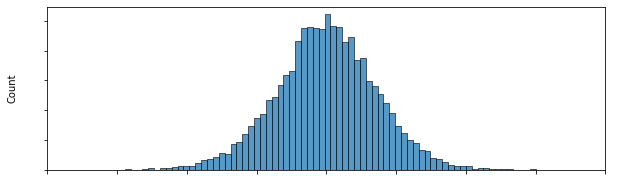

In [11]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

embeddings_np = embeddings.numpy()

print(f"mean of the embeddings values :::::::::: {embeddings_np.mean():.2f}")
print(f"std of the embeddings values ::::::::::: {embeddings_np.std():.2f}")
print(f"2.5% and 97.5% of the embeddings values ::: {np.percentile(embeddings_np, 2.5):.2f}, {np.percentile(embeddings_np, 97.5):.2f}")
plt.figure(figsize=(10,3))
plt.xlim(-0.2, 0.2)
plt.tick_params(axis="both", labelcolor="white")
sns.histplot(np.random.choice(embeddings.reshape(-1 , ), 10_000))
plt.show()

# Clustering module

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [43]:
class CosineSimilarity(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
        
    def forward(self, x, y):
        x_n, y_n = x.norm(dim=1)[:, None], y.norm(dim=1)[:, None]
        x_norm = x / torch.max(x_n, self.eps * torch.ones_like(x_n))
        y_norm = y / torch.max(y_n, self.eps * torch.ones_like(y_n))
        sim = torch.mm(y_norm, x_norm.transpose(0, 1))
        
        return sim

In [44]:
def top_k_row_indices(mat:torch.Tensor, num_top_k:int):
    """ Only works for 2D-tensors """
    ## Extract the largest element of each row
    top_one_element_of_each_row = torch.topk(mat, k=1, dim=1).values
    ## Get the row indices at which the top k elements exist
    row_indices = torch.topk(top_one_element_of_each_row, k=num_top_k, dim=0).indices
    row_indices = row_indices.flatten()
    
    return row_indices

In [45]:
class ADC(nn.Module):
    def __init__(
        self,
        num_centroids:int,
        num_top_k:int=BATCH_SIZE//2,
        embeddings=embeddings
    ):
        super().__init__()
        ## Assert
        self.num_centroids = num_centroids
        self.num_top_k = num_top_k
        self.embeddings = embeddings
        assert self.embeddings.size(0) > self.num_centroids, "The number of centroids cannot be larger than the number of data points."
        assert self.num_top_k < BATCH_SIZE, "k of top_k cannot be larger than batch size."
        ## Centroids initialization
        mu = torch.empty(self.num_centroids, self.embeddings.size(1))
        torch.nn.init.trunc_normal_(mu, mean=0.0, std=0.05, a=-0.1, b=0.1) # Similar to the embedding elements
        self.mu = nn.Parameter(mu)
        ## Layers
        self.cos = CosineSimilarity()
        
    def forward(self, d):
        ## Cosine similarity
        s = self.cos(self.mu, d) # [batch, mu]
        ## Samples with top k probabilities in current batch.
        if d.size(0)==BATCH_SIZE:
            top_indices = top_k_row_indices(s, num_top_k=self.num_top_k)
        else: # the last batch in iterator
            top_indices = top_k_row_indices(s, num_top_k=s.size(0)//2)
        topk_s = s.index_select(dim=0, index=top_indices)
        ## Softmax
        p_prime = F.softmax(topk_s, dim=1) # The sum of the membership probabilities of one document is 1.
        #p_prime = F.log_softmax(topk_s, dim=1) <--- Isn't log softmax more appropriate? IDK...
        ## Soft target
        y_tilde_prime = torch.argmax(p_prime.detach().clone(), dim=1)
        
        return p_prime, y_tilde_prime

# Training

In [64]:
from torch.optim import Adam, SGD

NUM_CENTROIDS = 30
NUM_TOP_K = BATCH_SIZE//16

adc = ADC(num_centroids=NUM_CENTROIDS, num_top_k=NUM_TOP_K).to(device)
criterion = nn.NLLLoss()
#optimizer = Adam(adc.parameters(), lr=1e-3)
optimizer = SGD(adc.parameters(), lr=1e-3)

In [65]:
import os
from glob import glob
import pickle
    
def save_model(directory, model, epoch, loss, empty_the_previous=True):
    ## Make a directory
    if directory not in os.listdir():
        os.mkdir("./" + directory)
    ## Get the centroids
    mu = model.mu.data.cpu()
    ## Empty the folder
    if empty_the_previous==True:
        [os.remove(f) for f in glob("./" + directory + "/*.pt")]
    ## Save the centroids
    torch.save(mu, "./" + directory + f"/EPOCH_{epoch}___LOSS_{loss:.4f}_.pt")

In [66]:
def train(batch, d, refresh_rate=30, verbose=False):
    data_size = len(dataloader.dataset)
    ## Ready
    adc.zero_grad()
    ## Set,,, Go!
    p, y = adc(d)
    loss = criterion(p, y)
    loss.backward()
    optimizer.step()
    ## End
    loss = loss.item()
    current = BATCH_SIZE * batch
    if batch%refresh_rate==0 and verbose==True:
        print(f"loss :: {loss:>5f}    [{current:>5d}/{data_size}]")
    
    return loss

In [67]:
import time

EPOCHS = 100_000
batch_log = []
epoch_log = []
endure_gage = 0
patient = 100
DIRECTORY = "log"

grand_start = time.time()
for epoch in range(EPOCHS):
    epoch_start = time.time()
    avg_loss = 0
    for batch, d in enumerate(dataloader):
        d = d.to(device)
        loss = train(batch, d, verbose=False)
        batch_log.append(loss)
        avg_loss += loss
    
    ## End
    avg_loss /= (len(dataloader.dataset) / BATCH_SIZE)
    ## Early Stopping
    if epoch_log:
        if min(epoch_log) <= avg_loss:
            endure_gage += 1
            if endure_gage >= patient:
                print(f"\n\nXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX\nEARLY STOPPED\nat epoch {epoch}\nXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
                break
        else:
            endure_gage = 0
            save_model(directory=DIRECTORY, model=adc, epoch=epoch, loss=avg_loss)
    else:
        save_model(directory=DIRECTORY, model=adc, epoch=epoch, loss=avg_loss)
    ## Log
    epoch_log.append(avg_loss)
    
    if epoch%20==0:
        print(f"EPOCH END {epoch} ------------------------------------------")
        print(f"average loss :: {avg_loss:.8f}")
        print(f"epoch time elapsed :: {(time.time()-epoch_start)/60:.2f}min")
        print(f"grand time elapsed :: {(time.time()-grand_start)/60:.2f}min")    

EPOCH END 0 ------------------------------------------
average loss :: -0.03711974
epoch time elapsed :: 0.02min
grand time elapsed :: 0.02min
EPOCH END 20 ------------------------------------------
average loss :: -0.03727600
epoch time elapsed :: 0.02min
grand time elapsed :: 0.42min
EPOCH END 40 ------------------------------------------
average loss :: -0.03771287
epoch time elapsed :: 0.02min
grand time elapsed :: 0.80min
EPOCH END 60 ------------------------------------------
average loss :: -0.03947841
epoch time elapsed :: 0.02min
grand time elapsed :: 1.19min
EPOCH END 80 ------------------------------------------
average loss :: -0.04262594
epoch time elapsed :: 0.02min
grand time elapsed :: 1.59min
EPOCH END 100 ------------------------------------------
average loss :: -0.04623364
epoch time elapsed :: 0.02min
grand time elapsed :: 1.97min
EPOCH END 120 ------------------------------------------
average loss :: -0.04980041
epoch time elapsed :: 0.02min
grand time elapsed ::

EPOCH END 1140 ------------------------------------------
average loss :: -0.07990941
epoch time elapsed :: 0.02min
grand time elapsed :: 22.33min
EPOCH END 1160 ------------------------------------------
average loss :: -0.08027038
epoch time elapsed :: 0.02min
grand time elapsed :: 22.71min
EPOCH END 1180 ------------------------------------------
average loss :: -0.08066385
epoch time elapsed :: 0.02min
grand time elapsed :: 23.09min
EPOCH END 1200 ------------------------------------------
average loss :: -0.08104860
epoch time elapsed :: 0.02min
grand time elapsed :: 23.48min
EPOCH END 1220 ------------------------------------------
average loss :: -0.08147090
epoch time elapsed :: 0.02min
grand time elapsed :: 23.87min
EPOCH END 1240 ------------------------------------------
average loss :: -0.08183209
epoch time elapsed :: 0.02min
grand time elapsed :: 24.26min
EPOCH END 1260 ------------------------------------------
average loss :: -0.08218290
epoch time elapsed :: 0.02min
gr

EPOCH END 2260 ------------------------------------------
average loss :: -0.09429902
epoch time elapsed :: 0.02min
grand time elapsed :: 44.21min
EPOCH END 2280 ------------------------------------------
average loss :: -0.09443426
epoch time elapsed :: 0.02min
grand time elapsed :: 44.60min
EPOCH END 2300 ------------------------------------------
average loss :: -0.09449703
epoch time elapsed :: 0.02min
grand time elapsed :: 44.98min
EPOCH END 2320 ------------------------------------------
average loss :: -0.09463151
epoch time elapsed :: 0.02min
grand time elapsed :: 45.38min
EPOCH END 2340 ------------------------------------------
average loss :: -0.09470898
epoch time elapsed :: 0.02min
grand time elapsed :: 45.76min
EPOCH END 2360 ------------------------------------------
average loss :: -0.09480426
epoch time elapsed :: 0.02min
grand time elapsed :: 46.16min
EPOCH END 2380 ------------------------------------------
average loss :: -0.09486337
epoch time elapsed :: 0.02min
gr

EPOCH END 3380 ------------------------------------------
average loss :: -0.09730275
epoch time elapsed :: 0.02min
grand time elapsed :: 67.00min
EPOCH END 3400 ------------------------------------------
average loss :: -0.09729527
epoch time elapsed :: 0.02min
grand time elapsed :: 67.41min
EPOCH END 3420 ------------------------------------------
average loss :: -0.09732152
epoch time elapsed :: 0.02min
grand time elapsed :: 67.82min
EPOCH END 3440 ------------------------------------------
average loss :: -0.09730966
epoch time elapsed :: 0.02min
grand time elapsed :: 68.21min
EPOCH END 3460 ------------------------------------------
average loss :: -0.09727886
epoch time elapsed :: 0.02min
grand time elapsed :: 68.60min
EPOCH END 3480 ------------------------------------------
average loss :: -0.09732781
epoch time elapsed :: 0.02min
grand time elapsed :: 69.00min
EPOCH END 3500 ------------------------------------------
average loss :: -0.09737762
epoch time elapsed :: 0.02min
gr

In [68]:
import pickle

with open("./" + DIRECTORY + "/batch_log.pkl", mode="wb") as f:
    pickle.dump(batch_log, f)
with open("./" + DIRECTORY + "/epoch_log.pkl", mode="wb") as f:
    pickle.dump(epoch_log, f)

# Visualize the losses

In [90]:
### The batch log is too long...
b_log = [x for i,x in enumerate(batch_log) if i%1_000==0]

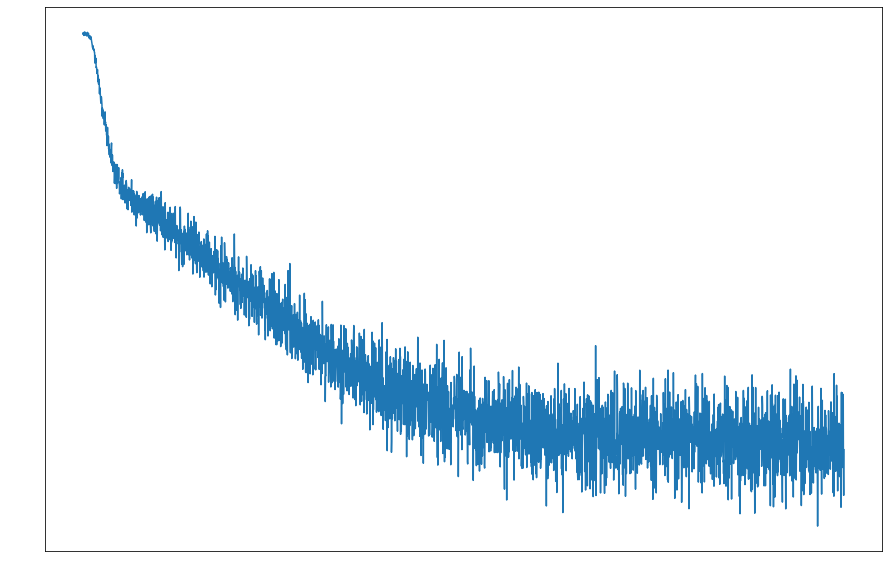

In [91]:
plt.figure(figsize=(15,10))
plt.tick_params(axis="both", colors="white")
sns.lineplot(x=range(len(b_log)), y=b_log)
plt.show()

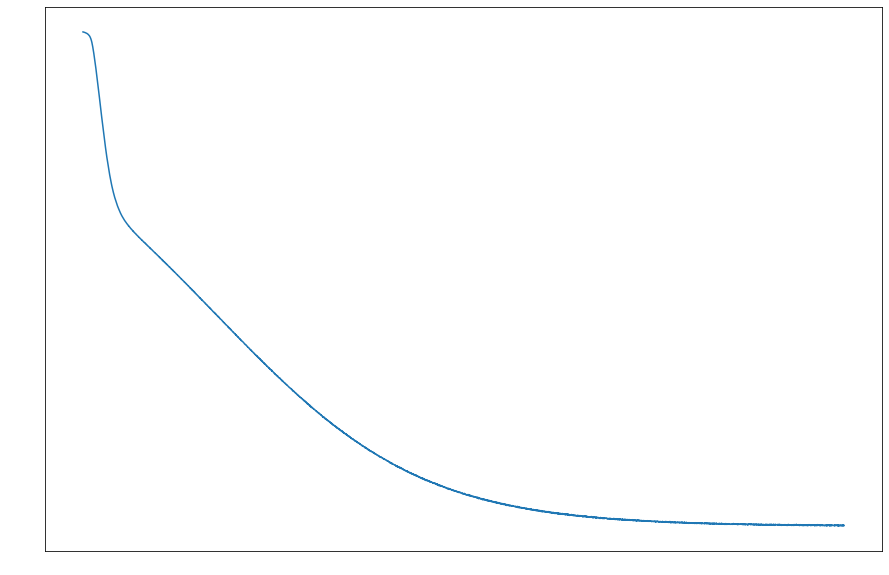

In [92]:
plt.figure(figsize=(15,10))
plt.tick_params(axis="both", colors="white")
sns.lineplot(x=range(len(epoch_log)), y=epoch_log)
plt.show()

# Check the trained centroids

In [93]:
from glob import glob

mu = torch.load(glob("./" + DIRECTORY + "/*pt")[0])

In [94]:
cos_sim = CosineSimilarity()(embeddings, mu)
cos_sim.shape

torch.Size([30, 100000])

In [95]:
def most_similar(cluster_idx:int, num:int):
    similarity = cos_sim[cluster_idx]
    indices = torch.topk(similarity, k=num).indices
    sentences = []
    for i in indices:
        sentences.append(data["text"].iloc[i.item()])
        
    return sentences

In [97]:
ms = most_similar(cluster_idx=0, num=10)
print(ms)

['Ritalin and adderall market research says they both tested well among focus groups.', 'Really want to try out a career in tracing, or something along those lines.', 'I have yet to see a television network try to improve their ratings by airing better quality shows.', 'I like to make my websites with ajax because that way my designs always come out very clean.', "You should always buy very high end speakers it's a sound investment", "I'm lactose intolerant, too. do the pills work for you? it's a crap shoot.", "There is a band called 1023 mb. they haven't had any gigs yet though.", "I'm looking for something with the health benefits of yoga but absolutely none of the yoga", "I don't have a summer home, but i do have several different email addresses.", 'Internet explorer is the best browser... to download another browser.']
